# Detección de tweets meteorológicos con Bag of Words

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#### Cargo la base de datos clasificada y genero las variables de importancia

In [3]:
TW = pd.read_csv('base_corr.csv')
MSJ = TW['Twit']
TAG = TW['Tag']
NUM = TW['Num']

### Defino una variable cantidad que tiene la cantidad de tw de cada tipo

In [4]:
cant = [len (np.array(TAG) [np.where(TAG == 0)]) , len (np.array(TAG) [np.where(TAG == 1)])]

#### Elimino las cosas innecesarias de msj

In [67]:
def normalizacion(mensaje):
    
    mensaje = list(mensaje)
    lenght = len(mensaje)
    
    lista_ascii = [['\\xe1', '\\xe9', '\\xed', '\\xf3', '\\xfa', '\\xf1', '\\xd1', '\\xc1','\\xc9', '\\xcd', '\\xd3', 
                 '\\xda', '\\xa1', '\\xbf', '\\xdc', '\\xfc', '\\xb4', '\\xba', '\\xaa', '\\xb7','\\xc7','\\xe7',
                 '\\xa8', '\\xb0C', '\\n', '\\xb0c', '\\xbb', 'xb0', '\\ufe0f'],
                   ['a', 'e', 'i', 'o', 'u', 'ñ', 'Ñ', 'A', 'E', 'I', 'O', 'U', '', '', 'Ü', 'ü', '', 
                           ' ', '', '','Ç','ç','', ' ', ' ', ' ', ' ', ' ', ' ']]
    lista_simb = ['!','\'', '\"', "|", '$', "%", "&", "(", ")", "=", "?", "+",'/', ";", "_", "-", "1","2",
                  "3","4","5","6","7","8","9","0", '*',',', '.', ':', '#']
    
    ign_palabras = ['mbar','cdu','s','la','lo','st','que','este', 'me','t','p','el','weathercloud','en','h',
                    'temp','hpa','km','mm',"su","vos",'que',"re","xq","le","te","tu","soy","sos","mi","da","o",
                    "x","les","me","d","q", "como", "lo", "los", "mi", "son", "a", "el", 
                    "un","la", "una","en","por","para", 'las',"ante", "al", 'me',"rt", "del", "y", "se", "de",
                    "que", "sus", "ha", "es", "con", "esta"]
    
    for i in range(lenght):
        
        ## Convierto mayúsculas en minúsculas
        mensaje[i] = mensaje[i].lower()
        
        ## Saco las menciones y otras cosas
        txt = mensaje[i].split()
        
        for j in range(len(txt)):
            if ('@' in txt[j]) and ('RELAMPAGO2018' not in txt[j]) and ('RELAMPAGO_edu' not in txt[j]) or ('jaj' in txt[j]) or ('https' in txt[j]): txt[j]=''
        
        mensaje[i] = " ".join(txt)
        
        ## Reemplazo símbolos
        for h in range(len(lista_simb)):
            mensaje[i] = mensaje[i].replace(lista_simb[h], ' ')
        
        
        for j in mensaje[i].split():
            if str(j).isascii()==False:
                mensaje[i] = mensaje[i].replace(str(j), '')
        
        ## Convierto el msj a ASCII, reemplazo los errores de decodificación y agrego un espacio antes de cada decodificación
        mensaje[i] = mensaje[i].encode('unicode-escape').decode('ASCII')+" "     

              
        
        for k in range(len(lista_ascii[0])):
            mensaje[i] = mensaje[i].replace(lista_ascii[0][k], lista_ascii[1][k])

        
        mensaje[i] = mensaje[i].replace('\\', ' \\')
        
        for j in range(len(ign_palabras)):
            mensaje[i] = mensaje[i].replace(" "+ign_palabras[j]+" ", ' ')
        
    return(mensaje)
msj = normalizacion(MSJ)
msj

['esta lloviendo ',
 'quiero ir centro  pero seguro llueve  ',
 ' si  llueve mucho     ',
 ' si llueve hago  ',
 'hasta  voy seguir teniendo miedo tormentas   ',
 '  climarafaela          hum        bar          lluvia      viento      sso  ',
 ' sea  sea   no hay plata  ahora llueve   cambia    estudiar igual ',
 'llueve no tengo internet   espera tremenda tarde ',
 'que linda noche lluvia  ',
 ' mucho calor  previo lluvias  ',
 'me gusta cuando llueve porque parece estan fritando empanadas  puesgorda  ',
 'noviembre sin ti sentir lluvia dice llorando todo   ',
 '  agvnet          hum        bar         lluvia    viento       ',
 'con lluvia dieron ganas cucharear    ',
 'y largo lluvia  ',
 'que hermosa tormenta ',
 ' dan lluvia  ',
 'aseguran hay stock suficiente bengalas combatir tormentas  ',
 ' final     cervezas amigos  estuve novio  comi milanesa napolitana   agua hirviendo estoy dormirme  limpias lluvia fondo gato lado  siento  realizada  ',
 'llueve pq sebastian levanto  ',
 

In [64]:
'hola'.encode('unicode-escape').decode('ASCII').isascii()

True

#### División en datasets de  _train_ y _test_

In [68]:
size = 0.8

## Toma los tweets, los asocia con su tag y luego los divide en cada una de las palabras que los componen
## zip() itera tuplas

train = [(i.split(),j) for i,j in zip(list(msj)[1:int(len(msj)*0.8)],list(TAG)[1:int(len(msj)*0.8)])]

test = [(i.split(),j) for i,j in zip(list(msj)[int(len(msj)*0.8)+1:len(msj)],list(TAG)[int(len(msj)*0.8)+1:len(msj)])]

## Guardo los labels, (en este caso 1 y 0) en un diccionario
label_to_ix = { 1: 0, 0: 1 } 

# 1 = Meteorológico
# 0 = No meteorológico



#### Generación del diccionario con el dataset completo

In [69]:
word_to_ix = {}

# El diccionario tiene que tener todas las palabras posibles
datos = train + test

## Cada palabra que encuentra la guarda en un diccionario
for sent, _ in datos:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2

#### Bag of Words

In [70]:
class BoWClassifier(nn.Module): # inheriting from nn.Module!
    
    def __init__(self, num_labels, vocab_size):
        
        super(BoWClassifier, self).__init__()

        self.linear1 = nn.Linear(vocab_size, 100)
        self.linear2 = nn.Linear(100, num_labels)
        
        
    def forward(self, bow_vec):
        
        h = self.linear1(bow_vec)
        
        y = self.linear2(h)
        
        soft = F.log_softmax(y , dim=1)
        
        return soft
    
    def make_bow_vector(sentence, word_to_ix):
        vec = torch.zeros(len(word_to_ix))
        for word in sentence:
            vec[word_to_ix[word]] += 1
        return vec.view(1, -1)

    def make_target(label, label_to_ix):
        
        return torch.LongTensor([label_to_ix[label]])
    


#### Miremos la frecuencia de ocurrencia de palabras en el diccionario

In [71]:
vec = torch.zeros(len(word_to_ix))
for i, label in test+train:
    bow_vector = BoWClassifier.make_bow_vector(i, word_to_ix)
    vec = vec.add(bow_vector)

vec=vec[0].tolist()

In [72]:
## Genero un dataframe que me pemite ordenar de mayor a menor respecto de la columna Frecuencia
tot = pd.DataFrame()
tot['Diccionario'] = list(word_to_ix.keys())
tot['Frecuencia'] = vec
tot['Num'] = word_to_ix.values()
tot = tot.sort_values(by=['Frecuencia'], ascending=False)

### Entrenamiento

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40


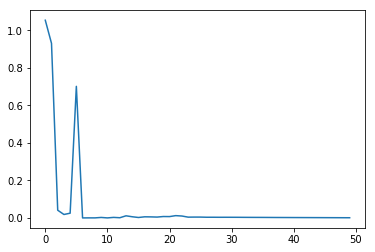

In [73]:
model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Se suele usar la cantidad de epocas que lleve a la estabilidad sin overfitear

error = []

for epoch in range(50):
    if epoch % 10 == 0: print('Epoch: %i' %epoch)
    for instance, label in train:
        
        
        # Hay que resetear los gradientes antes de hacer cuentas
        model.zero_grad()
    
        # Hacemos el vector de bag of words
        bow_vec = BoWClassifier.make_bow_vector(instance, word_to_ix)
        
        # Guardamos el label del diccionario de Tags
        target = BoWClassifier.make_target(label, label_to_ix)
    
        # Hacemos el forward pass.
        log_probs = model(bow_vec)
    
        # Calculamos el error
        loss = loss_function(log_probs, target)
    
        # Le pedimos a torch que busque los gradientes con back propagation
        
        loss.backward()
        
        # Usamos SGD para hacer back propagation y modificar los pesos
        optimizer.step()
    error.append(loss) 

   
plt.figure()
plt.plot(error)
plt.show()

## Usamos los twits de test para verificar

In [74]:
c = [0,0,0,0]
for instance, label in test:
    bow_vec = autograd.Variable(BoWClassifier.make_bow_vector(instance, word_to_ix))
    log_probs = model(bow_vec)
    log_probs_exp = log_probs.exp()
    if bool (log_probs_exp[0][0]>0.5):
        
        if label == 1: 
            c[0]+=1
           # print ('\033[1;93m' , log_probs_exp , label)
        else: 
            c[2]+=1
           # print ('\033[1;31m' , log_probs_exp , label)

    elif bool (log_probs_exp[0][1]>0.5):
        
        if label == 0:
            c[1]+=1
           # print ('\033[1;32m' , log_probs_exp , label)
            
        else:
            c[3]+=1
           # print ('\033[1;66m' , log_probs_exp , label)


print('\033[0m Aciertos a tweets meteorológicos:', round((c[0]/sum(c))*100, 3),
      '% \n Aciertos a tweets no meteorologicos:', round((c[1]/sum(c))*100, 3),
      '% \n Sorpresas: ', round((c[3]/sum(c))*100, 3),
      '% \n Falsos positivos: ', round((c[2]/sum(c))*100, 3), '%') 
print(c)
#print ('\033[0m', next(model.parameters())[:,word_to_ix["lluvia"]]) # Index corresponding to Spanish goes up, English goes down!



 Aciertos a tweets meteorológicos: 36.544 % 
 Aciertos a tweets no meteorologicos: 21.53 % 
 Sorpresas:  14.448 % 
 Falsos positivos:  27.479 %
[129, 76, 97, 51]


In [50]:
word_to_ix

{'quiero': 0,
 'ir': 1,
 'centro': 2,
 'pero': 3,
 'seguro': 4,
 'llueve': 5,
 'si': 6,
 'mucho': 7,
 '\\U0001f612': 8,
 'hago': 9,
 '\\U0001f917': 10,
 'hasta': 11,
 'cuando': 12,
 'voy': 13,
 'seguir': 14,
 'teniendo': 15,
 'miedo': 16,
 'tormentas': 17,
 '\\U0001f644': 18,
 '\\U0001f623': 19,
 'climarafaela': 20,
 'hum': 21,
 'bar': 22,
 'lluvia': 23,
 'viento': 24,
 'sso': 25,
 'sea': 26,
 'estacion': 27,
 'no': 28,
 'hay': 29,
 'plata': 30,
 'ahora': 31,
 'cambia': 32,
 'tenes': 33,
 'estudiar': 34,
 'igual': 35,
 'tengo': 36,
 'internet': 37,
 'espera': 38,
 'tremenda': 39,
 'tarde': 40,
 'que': 41,
 'linda': 42,
 'noche': 43,
 '\\U0001f496': 44,
 'miercoles': 45,
 'calor': 46,
 'previo': 47,
 'lluvias': 48,
 'me': 49,
 'gusta': 50,
 'porque': 51,
 'parece': 52,
 'estan': 53,
 'fritando': 54,
 'empanadas': 55,
 'puesgorda': 56,
 '\\U0001f602': 57,
 'noviembre': 58,
 'sin': 59,
 'ti': 60,
 'sentir': 61,
 'dice': 62,
 'llorando': 63,
 'todo': 64,
 'acabo': 65,
 '\\U0001f3b5': 66,
 

## Graficos de verificación

Text(0.5, 1.0, 'Comparativa')

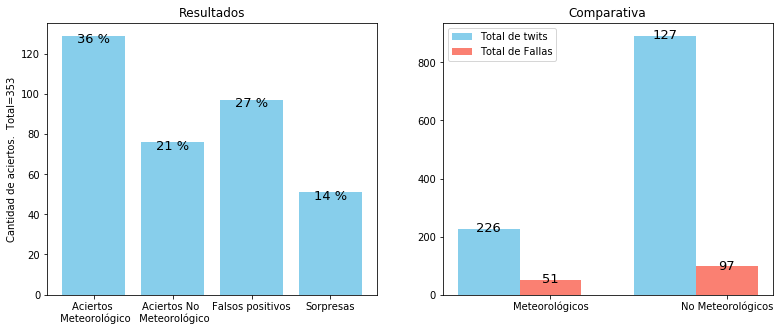

In [75]:
fig = plt.figure(figsize=(13,5))



opacity = 0.4
bar_width = 0.35


"""GRAFICO DE VERIFICACIÓN"""

ax = plt.subplot(1,2,1)

bar = plt.bar(range(4),c,
              tick_label=['Aciertos \n Meteorológico','Aciertos No \n Meteorológico',
                          'Falsos positivos','Sorpresas'], color = 'skyblue')
plt.title('Resultados')
plt.ylabel('Cantidad de aciertos.  Total='+str(sum(c)))
for rect, porcentaje in zip(bar,c):
    height = rect.get_height()- 5
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % round((porcentaje/sum(c))*100, 3) + ' %'
             ,fontsize = 13, color = 'black',ha='center', va='bottom')

  
"""GRÁFICO DE COMPARACIÓN PARA CADA TAG"""
    
ax2 = plt.subplot(1,2,2)

bar1 = plt.bar(np.arange(2), [c[0]+c[2],cant[1]+c[3]], bar_width, 
               tick_label = ['Meteorológicos', 'No Meteorológicos'],
               color = 'skyblue', label = 'Total de twits'
              )

for rect, porcentaje in zip(bar1,[c[0]+c[2],c[1]+c[3]]):
    height = rect.get_height()-20
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % porcentaje
             ,fontsize = 13, color = 'black',ha='center', va='bottom')


bar2 = plt.bar(np.arange(2) +bar_width, [c[3],c[2]], bar_width,
              tick_label = ['Meteorológicos', 'No Meteorológicos'],
               color = 'salmon' , label= 'Total de Fallas'
              )
for rect, porcentaje in zip(bar2,[c[3],c[2]]):
    height = rect.get_height()-20
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % porcentaje
             ,fontsize = 13, color = 'black',ha='center', va='bottom')

plt.legend()
plt.title('Comparativa')